In [80]:
# You need to replace these placeholders with your keys

consumer_key = 'CONSUMER_KEY_PLACEHOLDER'
consumer_secret = 'CONSUMER_SECRET_PLACEHOLDER'
access_token = 'ACCESS_TOKEN_PLACEHOLDER'
access_secret = 'ACCESS_SECRET_PLACEHOLDER'

In [81]:
# importing libraries
import pandas as pd
import requests
import tweepy
import numpy as np
import time
import json
import os
import contextlib
import warnings
import re
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('seaborn-darkgrid')

## Gathering data
---

In [82]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [83]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [84]:
# retrieve image predictions
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

# request from the url
req = requests.get(url)
if req.status_code == requests.codes.ok:
    req.encoding = 'utf-u'
    with open('image_predictions.txt', 'w') as infile:
        # write the text into the txt file
        infile.write(req.text)
        
# read the content using pandas 
df_image_predictions = pd.read_csv("image_predictions.txt", sep= '\t')

df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [85]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [86]:
# get the tweet IDs from df_archive and df_image_predictions
tweet_IDs = np.array(df_archive['tweet_id'].values, dtype = str)
tweet_IDs = np.concatenate((np.array(df_image_predictions['tweet_id'].values, dtype = str), tweet_IDs))
tweet_IDs = np.unique(tweet_IDs)
tweet_IDs

array(['666020888022790149', '666029285002620928', '666033412701032449',
       ..., '891815181378084864', '892177421306343426',
       '892420643555336193'],
      dtype='<U21')

In [87]:
#create the api instance
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

# create the lists where we will store the results from the twitter api
tweets = []
errors = []

for tweet_id in tweet_IDs:
    start = time.time()
    try:
        result = api.get_status(tweet_id, tweet_mode = 'extended')
        # Uncomment the lines below to see a JSON dump of one result
        # print(json.dumps(result, indent = 2))
        # break
        
        favorites = result['favorite_count']
        retweets = result['retweet_count']
        
        tweets.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets)})
    
    except Exception as e:
        errors.append(tweet_id)
    end = time.time()
    request_time = end - start
    print("time required: ", request_time)

time required:  0.5774540901184082
time required:  0.587993860244751
time required:  0.2572669982910156
time required:  0.28342294692993164
time required:  0.2644679546356201
time required:  0.2960703372955322
time required:  0.5456359386444092
time required:  0.5506749153137207
time required:  0.29311203956604004
time required:  0.26459312438964844
time required:  0.3122587203979492
time required:  0.26076221466064453
time required:  0.3038179874420166
time required:  0.2848830223083496
time required:  0.2536771297454834
time required:  0.2816319465637207
time required:  0.2684948444366455
time required:  0.32983922958374023
time required:  0.2805666923522949
time required:  0.2700939178466797
time required:  0.2598288059234619
time required:  0.3054349422454834
time required:  0.2611093521118164
time required:  0.2677600383758545
time required:  0.2643771171569824
time required:  0.31017017364501953
time required:  0.2619500160217285
time required:  0.263883113861084
time required:  

time required:  0.25859904289245605
time required:  0.3487269878387451
time required:  0.32170581817626953
time required:  0.31375789642333984
time required:  0.294036865234375
time required:  0.4083127975463867
time required:  0.32326388359069824
time required:  0.26207709312438965
time required:  0.28505802154541016
time required:  0.2797870635986328
time required:  0.26926279067993164
time required:  0.29487109184265137
time required:  0.2760739326477051
time required:  0.262706995010376
time required:  0.2743799686431885
time required:  0.30457115173339844
time required:  0.275972843170166
time required:  0.3057410717010498
time required:  0.5910739898681641
time required:  0.2631850242614746
time required:  0.6583359241485596
time required:  0.2897307872772217
time required:  0.2677500247955322
time required:  0.35852599143981934
time required:  0.26125383377075195
time required:  0.2711050510406494
time required:  0.3489549160003662
time required:  0.2746291160583496
time require

time required:  0.28449201583862305
time required:  0.2771890163421631
time required:  0.26507115364074707
time required:  0.26482605934143066
time required:  0.293898344039917
time required:  0.2822542190551758
time required:  0.28890419006347656
time required:  0.28106117248535156
time required:  0.28356003761291504
time required:  0.38806796073913574
time required:  0.30324506759643555
time required:  0.27492308616638184
time required:  0.335068941116333
time required:  0.7307841777801514
time required:  0.2634570598602295
time required:  0.27660608291625977
time required:  0.2900381088256836
time required:  0.29832911491394043
time required:  0.3167409896850586
time required:  0.2929849624633789
time required:  0.30352783203125
time required:  0.26940393447875977
time required:  0.2685418128967285
time required:  0.29676008224487305
time required:  0.8116908073425293
time required:  0.3585062026977539
time required:  0.560142993927002
time required:  0.30426812171936035
time requir

time required:  0.29767823219299316
time required:  0.3331890106201172
time required:  0.3124270439147949
time required:  0.3060181140899658
time required:  0.2981560230255127
time required:  0.27073001861572266
time required:  0.5294489860534668
time required:  0.30565595626831055
time required:  0.3079240322113037
time required:  0.3412928581237793
time required:  0.5804548263549805
time required:  0.35356903076171875
time required:  0.28424882888793945
time required:  0.2923698425292969
time required:  0.29001283645629883
time required:  0.26700592041015625
time required:  0.28220415115356445
time required:  0.3062739372253418
time required:  0.2725541591644287
time required:  0.29424285888671875
time required:  0.366649866104126
time required:  0.3493199348449707
time required:  0.2940101623535156
time required:  0.2736470699310303
time required:  0.26327013969421387
time required:  0.29194092750549316
time required:  0.31900596618652344
time required:  0.2966279983520508
time requ

time required:  0.25252199172973633
time required:  0.2695350646972656
time required:  0.3141036033630371
time required:  0.315108060836792
time required:  0.26873207092285156
time required:  0.26534080505371094
time required:  0.6340112686157227
time required:  0.27170586585998535
time required:  0.29533886909484863
time required:  0.26634693145751953
time required:  0.25127291679382324
time required:  0.2847282886505127
time required:  0.3042900562286377
time required:  0.3222541809082031
time required:  0.32549095153808594
time required:  0.25490880012512207
time required:  0.289168119430542
time required:  0.33240270614624023
time required:  0.27829599380493164
time required:  0.3040769100189209
time required:  0.2658848762512207
time required:  0.3755950927734375
time required:  0.2835242748260498
time required:  0.27585816383361816
time required:  0.2597939968109131
time required:  0.2713930606842041
time required:  0.3160219192504883
time required:  0.3242800235748291
time requi

time required:  0.26221203804016113
time required:  0.2900421619415283
time required:  0.26512813568115234
time required:  0.258242130279541
time required:  0.26006078720092773
time required:  0.31180882453918457
time required:  0.3231031894683838
time required:  0.3184387683868408
time required:  0.2770199775695801
time required:  0.27351999282836914
time required:  0.255950927734375
time required:  0.2636439800262451
time required:  0.30371809005737305
time required:  0.2589597702026367
time required:  0.2770810127258301
time required:  0.9359879493713379
time required:  0.524240255355835
time required:  0.28423404693603516
time required:  0.30997514724731445
time required:  0.28491997718811035
time required:  0.3027510643005371
time required:  0.26645708084106445
time required:  0.2866020202636719
time required:  0.2953629493713379
time required:  0.29200100898742676
time required:  0.33609867095947266
time required:  0.2993659973144531
time required:  0.3425474166870117
time requir

time required:  0.4322781562805176
time required:  0.2819819450378418
time required:  0.3070650100708008
time required:  0.32227087020874023
time required:  0.2669858932495117
time required:  0.3811671733856201
time required:  0.2903769016265869
time required:  0.2839698791503906
time required:  0.29769372940063477
time required:  0.3444812297821045
time required:  0.2926318645477295
time required:  0.37013888359069824
time required:  0.28629207611083984
time required:  0.2732701301574707
time required:  0.282116174697876
time required:  0.2878379821777344
time required:  0.313507080078125
time required:  0.30538296699523926
time required:  0.3525068759918213
time required:  0.3096001148223877
time required:  0.28713178634643555
time required:  0.2716958522796631
time required:  0.29050207138061523
time required:  0.34300899505615234
time required:  0.29291510581970215
time required:  0.27240896224975586
time required:  0.2645912170410156
time required:  0.3362438678741455
time require

time required:  0.28606486320495605
time required:  0.276867151260376
time required:  0.3034670352935791
time required:  0.301677942276001
time required:  0.3792109489440918
time required:  0.27372121810913086
time required:  0.29787611961364746
time required:  0.3316638469696045
time required:  0.27369093894958496
time required:  0.3061840534210205
time required:  0.3194890022277832
time required:  0.26314616203308105
time required:  0.28783607482910156
time required:  0.2653687000274658
time required:  0.3341948986053467
time required:  0.3021888732910156
time required:  0.26022982597351074
time required:  0.35233378410339355
time required:  0.2524428367614746
time required:  0.3215606212615967
time required:  0.30887794494628906
time required:  0.37447190284729004
time required:  0.34522414207458496
time required:  0.29408931732177734
time required:  0.37635374069213867
time required:  0.29068922996520996
time required:  0.29989099502563477
time required:  0.288754940032959
time req

time required:  0.31386804580688477
time required:  0.29804301261901855
time required:  0.608039140701294
time required:  0.25788211822509766
time required:  0.4731740951538086
time required:  0.695716142654419
time required:  0.36173391342163086
time required:  0.2788670063018799
time required:  0.2881739139556885
time required:  0.2675337791442871
time required:  0.3304018974304199
time required:  0.28280091285705566
time required:  0.297778844833374
time required:  0.2926671504974365
time required:  0.28781604766845703
time required:  0.2530369758605957
time required:  0.2642340660095215
time required:  0.2594921588897705
time required:  0.35965919494628906
time required:  0.3173840045928955
time required:  0.29350996017456055
time required:  0.32503795623779297
time required:  0.28104615211486816
time required:  0.3174147605895996
time required:  0.35654377937316895
time required:  0.35308194160461426
time required:  0.3023359775543213
time required:  0.255565881729126
time require

time required:  0.29759788513183594
time required:  0.27405881881713867
time required:  0.320004940032959
time required:  0.5932612419128418
time required:  0.2870321273803711
time required:  0.2636101245880127
time required:  0.3257029056549072
time required:  0.3050539493560791
time required:  0.28078699111938477
time required:  0.23694109916687012
time required:  0.2873871326446533
time required:  0.3011949062347412
time required:  0.45505475997924805
time required:  0.29086899757385254
time required:  0.30824804306030273
time required:  0.30155181884765625
time required:  0.30112409591674805
time required:  0.292874813079834
time required:  0.2835090160369873
time required:  0.2617058753967285
time required:  0.28757572174072266
time required:  0.2778749465942383
time required:  0.2872121334075928
time required:  0.278637170791626
time required:  0.28023600578308105
time required:  0.28066515922546387
time required:  0.2926771640777588
time required:  0.320742130279541
time require

time required:  0.28234028816223145
time required:  0.31046128273010254
time required:  0.3147122859954834
time required:  0.2577989101409912
time required:  0.32753419876098633
time required:  0.29375505447387695
time required:  0.30898618698120117
time required:  0.266643762588501
time required:  0.3514089584350586
time required:  0.33512425422668457
time required:  0.2837948799133301
time required:  0.25784802436828613
time required:  0.3100309371948242
time required:  0.2573549747467041
time required:  0.26521801948547363
time required:  0.29492712020874023
time required:  0.3223228454589844
time required:  0.2880220413208008
time required:  0.22933316230773926
time required:  0.3150358200073242
time required:  0.27024102210998535
time required:  0.5483410358428955
time required:  0.35946083068847656
time required:  0.2642781734466553
time required:  0.32554197311401367
time required:  0.3275179862976074
time required:  0.28900623321533203
time required:  0.3335390090942383
time re

In [88]:
print("The number of results from twitter", len(tweets))
print("The number of errors", len(errors))

The number of results from twitter 2347
The number of errors 9


In [89]:
with contextlib.suppress(FileNotFoundError):
    os.remove('tweet_json.txt')

df_json_tweets = pd.DataFrame(tweets, columns = ['tweet_id', 'favorites', 'retweets'])

df_json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)
df_json_tweets.head()

,tweet_id,favorites,retweets
0,666020888022790149,2530,523
1,666029285002620928,131,47
2,666033412701032449,126,46
3,666044226329800704,305,143
4,666049248165822465,110,40


## Assesing data
---

### Visual inspection

In [90]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [91]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


Observation: p1_conf > p2conf > p3_conf. Therefor it is not needed to keep p2, p2_conf, p2_dog, p3, p3_conf, p3_dog
Observation 2: Some pictures are not of dogs i.e. https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg identified by the neural network as hen shows indeed a hen.
Obervation 3: Some picture identified as not a dog are in fact dogs i.e. https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg identified as a shopping cart shows a dog sitting in a shopping cart.
        

In [92]:
df_json_tweets

,tweet_id,favorites,retweets
0,666020888022790149,2530,523
1,666029285002620928,131,47
2,666033412701032449,126,46
3,666044226329800704,305,143
4,666049248165822465,110,40
5,666050758794694657,135,59
6,666051853826850816,1241,868
7,666055525042405380,446,259
8,666057090499244032,303,144
9,666058600524156928,115,59


I do not notice anything remarkable in this table. 

### Programmatic inspection

In [93]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Observation: many variables have the wrong type i.e. object should be string for name source and text. 

In [94]:
df_archive.nunique()

tweet_id                      2356
in_reply_to_status_id         77  
in_reply_to_user_id           31  
timestamp                     2356
source                        4   
text                          2356
retweeted_status_id           181 
retweeted_status_user_id      25  
retweeted_status_timestamp    181 
expanded_urls                 2218
rating_numerator              40  
rating_denominator            18  
name                          957 
doggo                         2   
floofer                       2   
pupper                        2   
puppo                         2   
dtype: int64

In [95]:
df_archive.source.unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

Observation: Dirty. As observed before the sources are hard to read. As there only 4 different sources this is easy to fix with search and replace.

In [96]:
df_archive.doggo.unique()

array(['None', 'doggo'], dtype=object)

Observation: This is a tidyness issue doggo, floofer, pupper, puppo should be in one variabele.

In [97]:
df_archive['name'].value_counts()

None         745
a            55 
Charlie      12 
Cooper       11 
Lucy         11 
Oliver       11 
Penny        10 
Tucker       10 
Lola         10 
Winston      9  
Bo           9  
Sadie        8  
the          8  
an           7  
Buddy        7  
Toby         7  
Bailey       7  
Daisy        7  
Stanley      6  
Milo         6  
Bella        6  
Dave         6  
Koda         6  
Rusty        6  
Oscar        6  
Jax          6  
Leo          6  
Jack         6  
Scout        6  
Sammy        5  
            ..  
Snicku       1  
Amy          1  
Taz          1  
Ike          1  
Chloe        1  
Jeremy       1  
Ivar         1  
Claude       1  
such         1  
Dotsy        1  
Ferg         1  
Crimson      1  
Jarod        1  
Mona         1  
Hazel        1  
Berb         1  
Jimbo        1  
Alf          1  
Hanz         1  
Alejandro    1  
Aubie        1  
Clifford     1  
Hermione     1  
Bauer        1  
Karl         1  
Antony       1  
Goliath      1  
Cermet       1

This is a dirty data issue. Names like "None", "a" , "an", and "the" are not likely dog names. 

In [98]:
df_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

Observation: As mentioned in the assignment many numerators are above 10. This is not an issue.

In [99]:
df_archive['rating_denominator'].value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

Observation: Most keep the denominator on 10. A few choose another scale. Hmm I don't trust this. Time for an extra visual inspection.

In [100]:
pd.set_option('display.max_colwidth', -1)
df_not_ten = df_archive[df_archive['rating_denominator'] != 10]
df_not_ten[['tweet_id', 'text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


Observation: when the denominator is not 10 it is often caused by other fraction being misidentified as the rating i.e 7/11 the store or 3 1/2 legged or 11/15/15 the date.

In [101]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Observation: The 2075 records found here is below the records found for the df_archive dataset. Meaning that there are tweets without an image.

In [102]:
df_image_predictions.nunique()

tweet_id    2075
jpg_url     2009
img_num     4   
p1          378 
p1_conf     2006
p1_dog      2   
p2          405 
p2_conf     2004
p2_dog      2   
p3          408 
p3_conf     2006
p3_dog      2   
dtype: int64

In [103]:
df_image_predictions['jpg_url'].value_counts()

https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg                                            2
https://pbs.twimg.com/media/Cx5R8wPVEAALa9r.jpg                                            2
https://pbs.twimg.com/media/CxqsX-8XUAAEvjD.jpg                                            2
https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg                                            2
https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg                                            2
https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg                                            2
https://pbs.twimg.com/media/CrXhIqBW8AA6Bse.jpg                                            2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg                                            2
https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg                                            2
https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg                                            2
https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg                       

In [104]:
df_json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2347 entries, 0 to 2346
Data columns (total 3 columns):
tweet_id     2347 non-null int64
favorites    2347 non-null int64
retweets     2347 non-null int64
dtypes: int64(3)
memory usage: 55.1 KB


In [105]:
# this returns the number of unique values in each column
df_json_tweets.nunique()

tweet_id     2347
favorites    2015
retweets     1744
dtype: int64

### Tidiness issues (structual issues)
* To much information in df_image_predictions dataframe, (tweet_id and jpg_url is what we need)
* Various stages of dogs (doggo, floofer, pupper, puppo) are in four columns.
* All dataframes should be merged into one.

### Dirtiness issues (quality)
* wrong datatypes for several columns
* Tweets without images
* Dataset contains retweets
* Incorrect dog names
* Sources difficult to read
* Some tweet_ids have the same jpg_url
* Some pictures are not of dogs
* Some pictures are flagged as not a dog but are in fact of a dog.
* Fractions in the text are mistaken for rates.

## Cleaning data
---

### Creating copies of dataframes for cleaning

In [106]:
df_archive_clean = df_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_json_tweets_clean = df_json_tweets.copy()

### Define
The source column should be a category with four elements: "Twitter for iPhone", "Vine - Make a Scene", "Twitter Web Client", "TweetDeck" . In this step I remove the HTML tags using a simple regular expression and change the datatype to category.

### Code

In [107]:
df_archive_clean['source'] = df_archive_clean['source'].str.extract('>(.*?)</a>', expand= True)
df_archive_clean = df_archive_clean.astype({'source': "category"})

### Test

In [108]:
df_archive_clean['source'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

### Define
Create a single dog stage column and remove the four individual dog stage columns.

### Code

In [109]:
df_archive_clean['dog_stage'] = df_archive_clean['text'].str.extract('(doggo|floofer|pupper|puppo)', expand=True)
columns = ['doggo', 'floofer', 'pupper', 'puppo']
df_archive_clean = df_archive_clean.drop(columns, axis=1)

### Test

In [110]:
# Shows that there is a new column and the 4 original stage columns are removed
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null category
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     399 non-null object
dtypes: category(1), float64(4), int64(3), object(6)
memory usage: 241.8+ KB


In [111]:
df_archive_clean['dog_stage'].value_counts()

pupper     265
doggo      93 
puppo      37 
floofer    4  
Name: dog_stage, dtype: int64

### Define
Merge df_image_predictions_clean and df_json_tweets_clean into df_archive_clean.

### Code

In [112]:
df_archive_clean = df_archive_clean.merge(df_image_predictions_clean, on='tweet_id', how='inner')
df_archive_clean = df_archive_clean.merge(df_json_tweets_clean, on='tweet_id', how='inner')

### Test

In [113]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2068
Data columns (total 27 columns):
tweet_id                      2069 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2069 non-null object
source                        2069 non-null category
text                          2069 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2069 non-null object
rating_numerator              2069 non-null int64
rating_denominator            2069 non-null int64
name                          2069 non-null object
dog_stage                     337 non-null object
jpg_url                       2069 non-null object
img_num                       2069 non-null int64
p1                            2069 non-null object
p1_conf                       2069 

### Define
We want the original tweets. That means that we should only keep rows where retweeted_status_user_id and in_reply_to_user_id are null.

### Code

In [114]:
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_id'].isnull()]
df_archive_clean = df_archive_clean[df_archive_clean['in_reply_to_user_id'].isnull()]

### Test

In [115]:
df_archive_clean[df_archive_clean['retweeted_status_id'].notnull()].shape[0]

0

In [116]:
df_archive_clean[df_archive_clean['in_reply_to_user_id'].notnull()].shape[0]

0

### Define
Now that the retweets are removed all the columns related to retweets and replies can be removed also.

### Code

In [117]:
drop_columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 
                'in_reply_to_user_id', 'in_reply_to_status_id']
df_archive_clean = df_archive_clean.drop(drop_columns, axis=1)

### Test

In [118]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2068
Data columns (total 22 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null category
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             322 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null int64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null bool
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null bool
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null bool
favorites             1971 non-null int

### Define
Records without images should be removed.

### Code

In [119]:
df_archive_clean = df_archive_clean.dropna(subset=['expanded_urls'])

### Test

In [120]:
df_archive_clean[df_archive_clean['expanded_urls'].isnull()].shape[0]

0

### Define 
For the image predictions I only want to keep the one with the greatest confidence.

### Code

In [121]:
# First make sure p1_conf is always larger than p2_conf 
#(this might be obvious for a machine learning engineer but machine learning is my next nanodegree)
df_archive_clean[df_archive_clean['p1_conf'] < df_archive_clean['p2_conf']].shape[0]

0

In [122]:
# And make sure p1_conf is always larger than p3_conf
df_archive_clean[df_archive_clean['p1_conf'] < df_archive_clean['p3_conf']].shape[0]

0

In [123]:
# p1_conf is always greater than p2_conf and p3_conf so we can drop everything related to p2 and p3
drop_columns = ['p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
df_archive_clean = df_archive_clean.drop(drop_columns, axis=1)

### Test

In [124]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2068
Data columns (total 16 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null category
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             322 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null int64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null bool
favorites             1971 non-null int64
retweets              1971 non-null int64
dtypes: bool(1), category(1), float64(1), int64(6), object(7)
memory usage: 235.0+ KB


### Define
Change columns to the correct datatype.

### Code

In [125]:
df_archive_clean['dog_stage'] = df_archive_clean['dog_stage'].astype('category')
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])
df_archive_clean['tweet_id'] = df_archive_clean['tweet_id'].astype('str')
df_archive_clean['name'] = df_archive_clean['name'].astype('str')

### Test

In [126]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2068
Data columns (total 16 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null category
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             322 non-null category
jpg_url               1971 non-null object
img_num               1971 non-null int64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null bool
favorites             1971 non-null int64
retweets              1971 non-null int64
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), int64(5), object(6)
memory usage: 221.7+ KB


### Define
Fix the ratings that are not really ratings.

### Code

In [127]:
# First lets get an overview of the numerators
df_archive_clean.rating_numerator.value_counts()

12      446
10      417
11      392
13      253
9       150
8       95 
7       52 
5       33 
14      33 
6       32 
3       19 
4       16 
2       9  
1       5  
1776    1  
24      1  
26      1  
420     1  
27      1  
44      1  
45      1  
50      1  
60      1  
75      1  
80      1  
84      1  
88      1  
99      1  
121     1  
144     1  
165     1  
204     1  
0       1  
Name: rating_numerator, dtype: int64

In [128]:
# And the denominators
df_archive_clean.rating_denominator.value_counts()

10     1954
50     3   
80     2   
11     2   
170    1   
150    1   
120    1   
110    1   
90     1   
70     1   
40     1   
20     1   
7      1   
2      1   
Name: rating_denominator, dtype: int64

In [129]:
# Find the tweets with more than one %d/%d in the 'text' column. With %d being any number.
warnings.filterwarnings("ignore", 'This pattern has match groups')
df_archive_clean[df_archive_clean.text.str.contains( r"(\d+\/\d+\D+\d+\/\d+)")]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,favorites,retweets
612,777684233540206592,2016-09-19 01:42:24,Twitter for iPhone,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",https://twitter.com/dog_rates/status/777684233540206592/photo/1,12,10,None,NaN,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,cocker_spaniel,0.253442,True,12374,3347
821,747600769478692864,2016-06-28 01:21:27,Twitter for iPhone,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,"https://twitter.com/dog_rates/status/747600769478692864/photo/1,https://twitter.com/dog_rates/status/747600769478692864/photo/1",10,10,Bookstore,NaN,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,Chesapeake_Bay_retriever,0.804363,True,2524,611
872,740373189193256964,2016-06-08 02:41:38,Twitter for iPhone,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,NaN,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,0.807644,True,37560,14851
963,722974582966214656,2016-04-21 02:25:47,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,NaN,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,Great_Dane,0.246762,True,4430,1735
997,716439118184652801,2016-04-03 01:36:11,Twitter for iPhone,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,0.396495,True,2546,243
1013,714258258790387713,2016-03-28 01:10:13,Twitter for iPhone,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,https://twitter.com/dog_rates/status/714258258790387713/photo/1,10,10,Travis,NaN,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,1,collie,0.176758,True,3240,798
1135,703356393781329922,2016-02-26 23:10:06,Twitter for iPhone,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,https://twitter.com/dog_rates/status/703356393781329922/photo/1,9,10,Socks,NaN,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,1,Border_collie,0.894842,True,2058,426
1225,695064344191721472,2016-02-04 02:00:27,Twitter for iPhone,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",https://twitter.com/dog_rates/status/695064344191721472/video/1,4,10,None,NaN,https://pbs.twimg.com/ext_tw_video_thumb/695064251149508610/pu/img/0OPED0aUurb9Z16a.jpg,1,seat_belt,0.522211,False,1747,673
1230,694352839993344000,2016-02-02 02:53:12,Twitter for iPhone,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,"https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.com/dog_rates/status/694352839993344000/photo/1",10,10,Oliviér,NaN,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,2,Australian_terrier,0.407886,True,2205,691
1265,691483041324204033,2016-01-25 04:49:38,Twitter for iPhone,When bae says they can't go out but you see them with someone else t

Observations:
TweetId 740373189193256964: Rating received 9/11 should be 14/10
TweetId 722974582966214656: Rating received 4/20 should be 13/10
TweetId 716439118184652801: Rating received 50/50 should be 11/10
TweetId 682962037429899265: Rating received 7/11 should be 10/10
TweetId 666287406224695296: Rating received 1/2 should be 9/10
The other cases are caused by multiple dogs or a dog and another creature. In this case I kept the first one.

In [130]:
def set_fraction(tweet_id, numerator, denominator):
    target_index = df_archive_clean.loc[df_archive_clean['tweet_id']==tweet_id].index[0]
    df_archive_clean.loc[target_index, 'rating_numerator'] = numerator
    df_archive_clean.loc[target_index, 'rating_denominator'] = denominator

set_fraction('740373189193256964', 14, 10)
set_fraction('722974582966214656', 13, 10)
set_fraction('716439118184652801', 11, 10)
set_fraction('682962037429899265', 10, 10)
set_fraction('666287406224695296', 9, 10)

### Test

In [131]:
changed_tweets = ['740373189193256964', '722974582966214656', 
                  '716439118184652801', '682962037429899265', '666287406224695296']
df_archive_clean.loc[df_archive_clean['tweet_id'].isin(changed_tweets), 
                     ['tweet_id', 'rating_numerator', 'rating_denominator']]

,tweet_id,rating_numerator,rating_denominator
872,740373189193256964,14,10
963,722974582966214656,13,10
997,716439118184652801,11,10
1401,682962037429899265,10,10
2048,666287406224695296,9,10


### Define
Remove rows for which no rating is given

### Code

In [132]:
# First a visual observation
df_not_ten = df_archive_clean[df_archive_clean['rating_denominator'] != 10]
df_not_ten[['tweet_id','text','rating_denominator']]
# the number is small so I can check visually

,tweet_id,text,rating_denominator
342,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
412,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
730,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
920,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1018,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90
1043,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80
1061,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50
1127,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,50
1203,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,40
1376,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,110


In [133]:
# only 810984652412424192 has no rating the other ratings are for some reason (mostly multiple dogs) not out of 10
df_archive_clean = df_archive_clean[df_archive_clean.tweet_id != '810984652412424192']

### Test

In [134]:
df_archive_clean[df_archive_clean.tweet_id == '810984652412424192']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,favorites,retweets


### Define
Make sure all ratings are out of 10

### Code

In [135]:
df_archive_clean['rating_numerator'] = (df_archive_clean['rating_numerator'] * 10 / 
                                        df_archive_clean['rating_denominator'])
df_archive_clean['rating_numerator'] = df_archive_clean['rating_numerator'].astype(int)
# We no longer need the rating_denominator column
df_archive_clean = df_archive_clean.drop('rating_denominator', axis=1)

### Test

In [136]:
# For example I now expect for tweet_id 697463031882764288 which had a rating of 44/40 to now have a numerator of 11.
df_archive_clean[df_archive_clean.tweet_id == '697463031882764288']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,favorites,retweets
1203,697463031882764288,2016-02-10 16:51:59,Twitter for iPhone,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,11,None,NaN,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,Labrador_retriever,0.999885,True,3700,1538


In [137]:
# Check that the rating_denominator column disapeared
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1970 entries, 0 to 2068
Data columns (total 15 columns):
tweet_id            1970 non-null object
timestamp           1970 non-null datetime64[ns]
source              1970 non-null category
text                1970 non-null object
expanded_urls       1970 non-null object
rating_numerator    1970 non-null int64
name                1970 non-null object
dog_stage           322 non-null category
jpg_url             1970 non-null object
img_num             1970 non-null int64
p1                  1970 non-null object
p1_conf             1970 non-null float64
p1_dog              1970 non-null bool
favorites           1970 non-null int64
retweets            1970 non-null int64
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 206.2+ KB


### Define
Fix the invalid dog names.

In [138]:
# Before we move to the coding let us first have a visual glance. For starters dogname 'None'is invalid.
df_none = df_archive_clean[df_archive_clean.name == 'None']
df_none['text']

5       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh   
7       When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq                       
12      Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm                                   
23      You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV                                                     
24      This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp            
33      Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happe

In [139]:
# some more invalid names
df_lower_case = df_archive_clean[df_archive_clean.name.str.islower()]
df_lower_case['text']

21      I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba                              
50      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF       
139     We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9              
153     Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
290     Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK                                                          
435     We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/

In [140]:
# some more invalid names
df_one_letter = df_archive_clean[df_archive_clean.name.str.len() == 1]
df_one_letter['text']

50      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
520     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
620     This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC                                      
643     Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn               
818     This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
820     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
829     This is 

### Observations
Many texts simply have no dog names. So we can't resolve all
Dogs are often introduced with "This is Dogname", "Meet Dogname", "Their names are Dogname1 and Dogname2", "Her name is Dogname", "named Dogname", "His name is Dogname"
Note that we considder only dognames that are cappitalized. So "This is Fred" is a match and "This is the" is not.

### Code

In [141]:
# Rename the old 'name' colmn to old_name
df_archive_clean.rename(columns = {'name':'old_name'}, inplace = True)
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1970 entries, 0 to 2068
Data columns (total 15 columns):
tweet_id            1970 non-null object
timestamp           1970 non-null datetime64[ns]
source              1970 non-null category
text                1970 non-null object
expanded_urls       1970 non-null object
rating_numerator    1970 non-null int64
old_name            1970 non-null object
dog_stage           322 non-null category
jpg_url             1970 non-null object
img_num             1970 non-null int64
p1                  1970 non-null object
p1_conf             1970 non-null float64
p1_dog              1970 non-null bool
favorites           1970 non-null int64
retweets            1970 non-null int64
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 206.2+ KB


In [142]:
names = []

for text in df_archive_clean['text']:
    # Start with 'This is ' and the first letter of the name is uppercase
    if text.startswith('This is ') and re.match(r'[A-Z].*', text.split()[2]):
        names.append(text.split()[2].strip(',').strip('.'))
    # Start with 'Meet ' and the first letter of the name is uppercase
    elif text.startswith('Meet ') and re.match(r'[A-Z].*', text.split()[1]):
        names.append(text.split()[1].strip(',').strip('.'))
    # Contain 'names are' and the first letter of the name is uppercase
    elif 'names are' in text and re.match(r'[A-Z].*', text.split()[text.split().index('names') + 2]):
        names.append(text.split()[text.split().index('names') + 2].strip(',').strip('.'))
    # Contain 'name is' and the first letter of the name is uppercase
    elif 'name is' in text and re.match(r'[A-Z].*', text.split()[text.split().index('name') + 2]):
        names.append(text.split()[text.split().index('name') + 2].strip(',').strip('.'))
    # Contain 'named' and the first letter of the name is uppercase
    elif 'named' in text and re.match(r'[A-Z].*', text.split()[text.split().index('named') + 1]):
        names.append(text.split()[text.split().index('named') + 1].strip(',').strip('.'))
    else:
        names.append('None')
        
df_archive_clean['name'] = names

In [143]:
print("New column dog_name count \n", df_archive_clean.name.value_counts())
print("Old column name count \n", df_archive_clean.old_name.value_counts())

New column dog_name count 
 None            689
Charlie         10 
Lucy            9  
Cooper          9  
Tucker          9  
Oliver          8  
Penny           8  
Lola            7  
Winston         7  
Daisy           7  
Stanley         6  
Toby            6  
Koda            6  
Bella           6  
Bo              6  
Jax             6  
Sadie           6  
Scout           5  
Oscar           5  
Zoey            5  
Milo            5  
Buddy           5  
Chester         5  
Louis           5  
Rusty           5  
Bailey          5  
Sophie          4  
Alfie           4  
Cassie          4  
Scooter         4  
               ..  
Al              1  
Jeremy          1  
Ashleigh        1  
Daryl           1  
Chompsky        1  
Mona            1  
Dotsy           1  
Stubert         1  
Swagger         1  
Monty           1  
Remus           1  
Cal             1  
Dobby           1  
Cleopatricia    1  
Pavlov          1  
Stormy          1  
Eazy-E          1  
Raphael     

In [144]:
# remove the old names column
del df_archive_clean['old_name']
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1970 entries, 0 to 2068
Data columns (total 15 columns):
tweet_id            1970 non-null object
timestamp           1970 non-null datetime64[ns]
source              1970 non-null category
text                1970 non-null object
expanded_urls       1970 non-null object
rating_numerator    1970 non-null int64
dog_stage           322 non-null category
jpg_url             1970 non-null object
img_num             1970 non-null int64
p1                  1970 non-null object
p1_conf             1970 non-null float64
p1_dog              1970 non-null bool
favorites           1970 non-null int64
retweets            1970 non-null int64
name                1970 non-null object
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 206.2+ KB


### Test

In [145]:
# Check for one letter names
df_one_letter = df_archive_clean[df_archive_clean.name.str.len() == 1]
df_one_letter

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,favorites,retweets,name


In [146]:
# Check for lower case names
df_lower_case = df_archive_clean[df_archive_clean.name.str.islower()]
df_lower_case

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,favorites,retweets,name


Note there are still tweets with name == 'None' simply because a lot of tweets did not give the dogs name.

## Storing the cleaned data

In [147]:
df_archive_clean.to_csv('twitter_archive_cleaned_and_shiny.csv', index=False, encoding = 'utf-8')

## Weratedogs analysis
---
### Introduction

WeRateDogs is a Twitter channel that rates people's dogs with a humorous comment about the dog. It was started in 2015 by college student Matt Nelson. This dataset runs from November 2015 up to august 2017.

In [148]:
df = pd.read_csv('twitter_archive_cleaned_and_shiny.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970 entries, 0 to 1969
Data columns (total 15 columns):
tweet_id            1970 non-null int64
timestamp           1970 non-null object
source              1970 non-null object
text                1970 non-null object
expanded_urls       1970 non-null object
rating_numerator    1970 non-null int64
dog_stage           322 non-null object
jpg_url             1970 non-null object
img_num             1970 non-null int64
p1                  1970 non-null object
p1_conf             1970 non-null float64
p1_dog              1970 non-null bool
favorites           1970 non-null int64
retweets            1970 non-null int64
name                1970 non-null object
dtypes: bool(1), float64(1), int64(5), object(8)
memory usage: 217.5+ KB


In [149]:
# hmm apparently when you save a datframe into a csv file and read that csv file in another 
#jupyter file the datatypes are lost.
# Let us fix
df['dog_stage'] = df['dog_stage'].astype('category')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['tweet_id'] = df['tweet_id'].astype('str')
df['name'] = df['name'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970 entries, 0 to 1969
Data columns (total 15 columns):
tweet_id            1970 non-null object
timestamp           1970 non-null datetime64[ns]
source              1970 non-null object
text                1970 non-null object
expanded_urls       1970 non-null object
rating_numerator    1970 non-null int64
dog_stage           322 non-null category
jpg_url             1970 non-null object
img_num             1970 non-null int64
p1                  1970 non-null object
p1_conf             1970 non-null float64
p1_dog              1970 non-null bool
favorites           1970 non-null int64
retweets            1970 non-null int64
name                1970 non-null object
dtypes: bool(1), category(1), datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 204.2+ KB


### Some initial plots

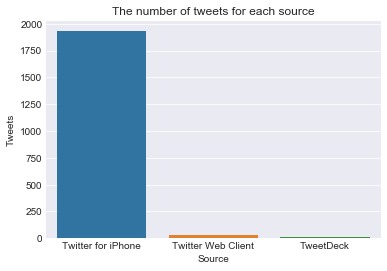

In [150]:
source_plot = sns.countplot(df['source'])
source_plot.set_title('The number of tweets for each source')
source_plot.axes.xaxis.label.set_text('Source')
source_plot.axes.yaxis.label.set_text('Tweets')

This plot shows the tweets per source. THe number of tweets from the iPhone client dwarphs the others sources.

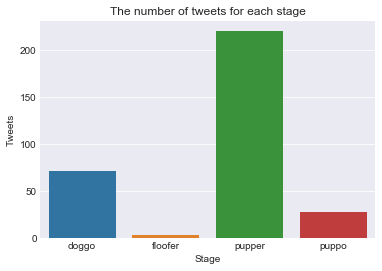

In [151]:
stages_plot = sns.countplot(df['dog_stage'])
stages_plot.set_title('The number of tweets for each stage')
stages_plot.axes.xaxis.label.set_text('Stage')
stages_plot.axes.yaxis.label.set_text('Tweets')

Puppers are by far the dogs most tweeted about. Followed at some distance by doggo and puppo. Foofer is hardly present at all.

### Dog tweets over time

Text(0.5,0,'Month')

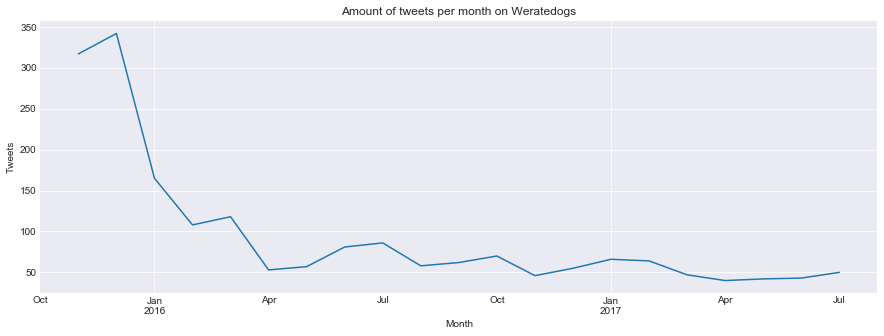

In [152]:
df['month'] = df['timestamp'].dt.floor('d') - pd.offsets.MonthBegin(1)
df['counter'] = 1
df_month = df[['counter','month']].groupby('month').count()
plot_title = 'Amount of tweets per month on Weratedogs'
ax = df_month['counter'].plot(figsize=(15, 5), title=plot_title)
ax.set_ylabel('Tweets')
ax.set_xlabel('Month')

The plot above shows a high rate of weets at the beginning of weratedogs followed by a rapid decay. From April 2016 up to July 2017 (the end of the dataset) the amount of tweets is fluctuating from 40 to 90 tweets per month. Note that these are original tweets retweets have been eliminated from the dataset.

### Rating inflation

Text(0,0.5,'Rating out of 10')

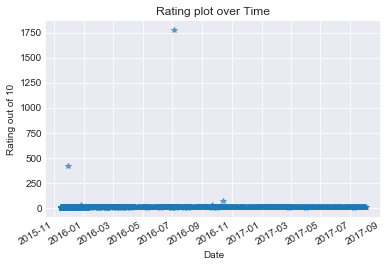

In [153]:
df = df.set_index('timestamp')
df.plot(y ='rating_numerator', style = '*', alpha = .6, legend = False)
plt.title('Rating plot over Time')
plt.xlabel('Date')
plt.ylabel('Rating out of 10')

I wanted to print the rating that are given to dogs over time. In my first attempt shown above I noticed there were a few outliers that dominated the plot. So In the plot below I limited the y axis. A little bit of trial showed that a limit from 0 to 16 gave the best results.

Text(0,0.5,'Rating out of 10')

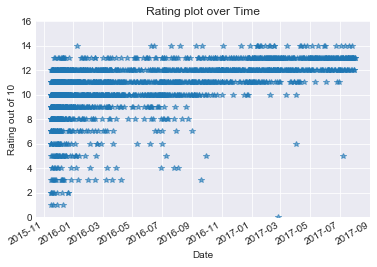

In [154]:
df.plot(y ='rating_numerator', ylim=[0,16], style = '*', alpha = .6, legend = False)
plt.title('Rating plot over Time')
plt.xlabel('Date')
plt.ylabel('Rating out of 10')

The plot above clearly shows that lower ratings lower raatings were given mainly at the beginning of weratedogs. Higher ratings as 13/10 and 14/10 were rare at the beginning and more prevalent at the end of our dataset.

### The most popular dog breeds

Text(0,0.5,'Count')

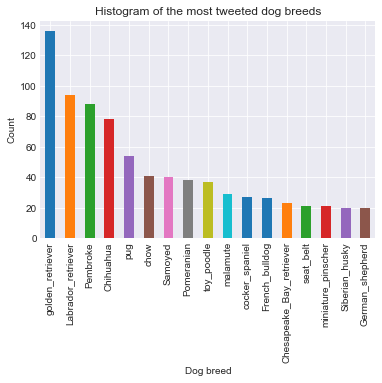

In [155]:
df_by_breed = df.groupby('p1').filter(lambda breed: len(breed) >= 20)

df_by_breed['p1'].value_counts().plot(kind = 'bar')
plt.title('Histogram of the most tweeted dog breeds')
plt.xlabel('Dog breed')
plt.ylabel('Count')

The plot shows the 20 most tweeted dog breeds. I had to limit the number of breeds to 20 otherwise the plot became unreadable. Note that not every "breed" is actually a dog. While I am not an expert on dogs I am pretty sure there is no dog breed called "seat belt". So for the plot below I am filtering out the tweets where the neural network identified the picture as not a dog.

Text(0,0.5,'Count')

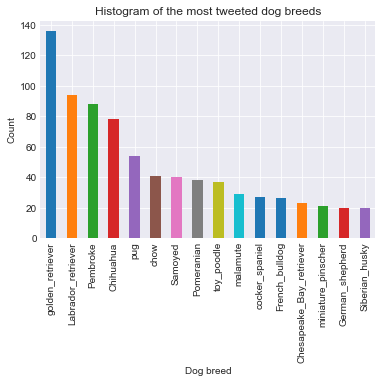

In [156]:
df_is_dog = df[df['p1_dog'] == True]
df_by_breed = df_is_dog.groupby('p1').filter(lambda breed: len(breed) >= 20)

df_by_breed['p1'].value_counts().plot(kind = 'bar')
plt.title('Histogram of the most tweeted dog breeds')
plt.xlabel('Dog breed')
plt.ylabel('Count')

Interestingly when tweets are filtered out that the neural network identified as not a dog I am left with only 14 breeds. Machine learning is not yet perfect though, "toy poodle" and "miniature pincher" are identified as dogs. Anyway the golden retriever is by far the most popular dog.